In [ ]:
import requests
import json
import folium
import polyline

def geocode_address(address):
    """Convert an address to coordinates using Nominatim (OpenStreetMap's geocoder)"""
    # Use Nominatim API for geocoding (free)
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": address,
        "format": "json",
        "limit": 1
    }
    
    # Add a user-agent header (required by Nominatim's terms of use)
    headers = {
        "User-Agent": "air-quality-route-planner/1.0"
    }
    
    response = requests.get(url, params=params, headers=headers)
    
    if response.status_code != 200 or not response.json():
        print(f"Error: Could not geocode address '{address}'")
        return None
    
    # Extract latitude and longitude
    result = response.json()[0]
    lat = float(result["lat"])
    lon = float(result["lon"])
    display_name = result["display_name"]
    
    print(f"Geocoded '{address}' to '{display_name}' at coordinates: {lat}, {lon}")
    return (lat, lon)

def get_osrm_routes(start_address, end_address, alternatives=True):
    """Get routes between two addresses"""
    # First, geocode the addresses to coordinates
    start_coords = geocode_address(start_address)
    end_coords = geocode_address(end_address)
    
    if not start_coords or not end_coords:
        return None
    
    # OSRM expects coordinates as lon,lat (not lat,lon)
    start_lon, start_lat = start_coords[1], start_coords[0]
    end_lon, end_lat = end_coords[1], end_coords[0]
    
    # Construct the OSRM API URL
    url = f"https://router.project-osrm.org/route/v1/driving/{start_lon},{start_lat};{end_lon},{end_lat}"
    
    # Add parameters
    params = {
        "overview": "full",  # Get detailed route geometry
        "alternatives": "true" if alternatives else "false",  # Get alternative routes
        "steps": "true",     # Include turn-by-turn directions
        "annotations": "true" # Get additional data like speed
    }
    
    # Make the request
    response = requests.get(url, params=params)
    
    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        return None
    
    routes_data = response.json()
    
    # Return data and the resolved coordinates
    return {
        "routes_data": routes_data,
        "start_coords": start_coords,
        "end_coords": end_coords
    }

# Example usage
if __name__ == "__main__":
    # Use addresses instead of coordinates
    start_address = "Empire State Building, New York"
    end_address = "Fenway Park, Boston"
    
    print(f"Finding routes from '{start_address}' to '{end_address}'...")
    result = get_osrm_routes(start_address, end_address)
    
    if result:
        routes_data = result["routes_data"]
        start_coords = result["start_coords"]
        end_coords = result["end_coords"]
        
        print(f"Found {len(routes_data['routes'])} routes")
        
        # Print route summaries
        for i, route in enumerate(routes_data['routes']):
            distance_km = round(route['distance'] / 1000, 2)
            duration_min = round(route['duration'] / 60, 2)
            print(f"Route {i+1}: {distance_km} km, {duration_min} minutes")
        
        # Visualize routes on a map (using the function from previous example)
        map_viz = visualize_routes(routes_data, start_coords, end_coords)
        if map_viz:
            # Save map to HTML file
            map_viz.save('routes_map.html')
            print("\nMap saved to 'routes_map.html'")
    else:
        print("Failed to retrieve routes")

Finding routes from 'Empire State Building, New York' to 'Fenway Park, Boston'...
Geocoded 'Empire State Building, New York' to 'Empire State Building, 350, 5th Avenue, Koreatown, Manhattan Community Board 5, Manhattan, New York County, City of New York, New York, 10118, United States' at coordinates: 40.74844205, -73.98565890160751
Geocoded 'Fenway Park, Boston' to 'Fenway Park, 4, Jersey Street, Audubon Circle, Fenway-Kenmore, Boston, Suffolk County, Massachusetts, 02115, United States' at coordinates: 42.346461399999995, -71.09709985343964
Found 2 routes
Route 1: 336.81 km, 274.84 minutes
Route 2: 361.2 km, 295.94 minutes

Map saved to 'routes_map.html'


: 


Testing location geocoding for: Kuala Lumpur, Malaysia

✅ Successfully geocoded location
Full address: Kuala Lumpur, Malaysia
Coordinates: 3.1526589, 101.7022205
Testing real-time air quality data for coordinates: 3.1526589, 101.7022205

✅ Successfully retrieved real-time air quality data
City: Kuala Lumpur
State: Kuala Lumpur
Country: Malaysia
Current AQI (US): 55
Current AQI (China): 16
Main Pollutant: p2

Temperature: 28°C
Humidity: 79%
Wind Speed: 1.54 m/s

Testing historical air quality data for Kuala Lumpur, Kuala Lumpur, Malaysia

⚠️ IQAir AirVisual API free tier doesn't provide historical data
However, we can access current data for this city:
Current AQI (US): 55
Main Pollutant: p2

To get historical data, you would need:
1. IQAir AirVisual Pro subscription
2. Or collect data over time by scheduling regular API calls
3. Or use a different data source like WAQI or local Malaysian government data

Creating simulated historical data for demonstration...

Simulated plot saved as 

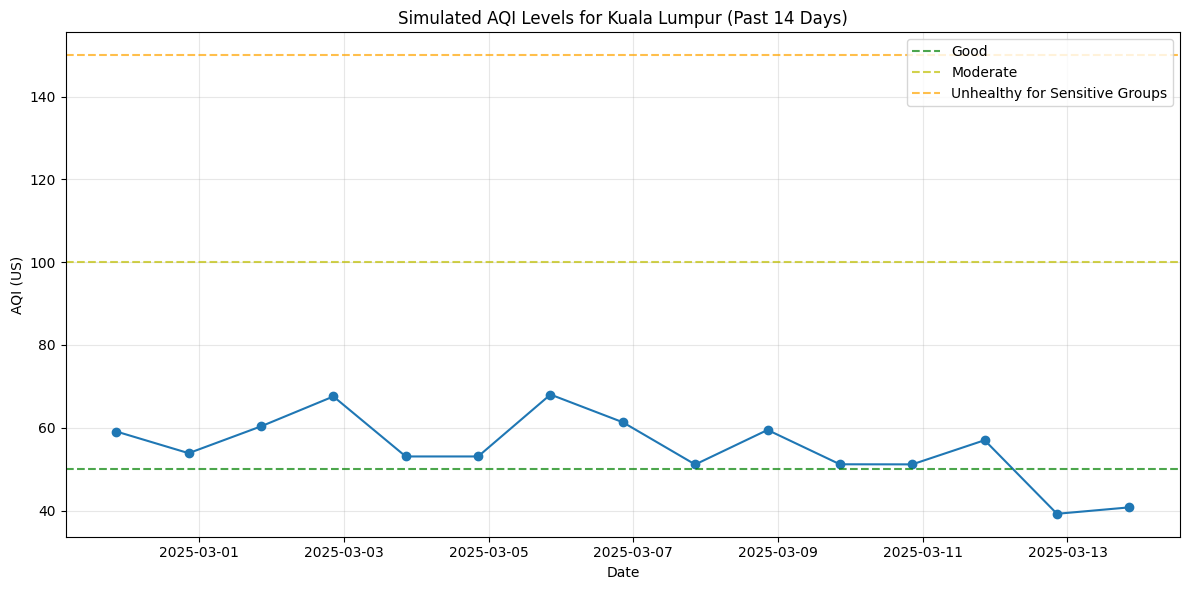

In [5]:
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import os

# You need to get an API key from IQAir at https://www.iqair.com/air-pollution-data-api
# Once you have it, either set it here or as an environment variable
API_KEY = os.environ.get("IQAIR_API_KEY", "12e0734a-a7c9-42df-801d-81c449525900")

def test_iqair_current_data(lat, lon):
    """Test if we can get real-time air quality data for a location"""
    print(f"Testing real-time air quality data for coordinates: {lat}, {lon}")
    
    url = "https://api.airvisual.com/v2/nearest_city"
    params = {
        "lat": lat,
        "lon": lon,
        "key": API_KEY
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if data.get("status") == "success" and data.get("data"):
            print("\n✅ Successfully retrieved real-time air quality data")
            
            result = data["data"]
            current = result.get("current", {})
            pollution = current.get("pollution", {})
            
            print(f"City: {result.get('city')}")
            print(f"State: {result.get('state')}")
            print(f"Country: {result.get('country')}")
            print(f"Current AQI (US): {pollution.get('aqius')}")
            print(f"Current AQI (China): {pollution.get('aqicn')}")
            print(f"Main Pollutant: {pollution.get('mainus')}")
            
            weather = current.get("weather", {})
            print(f"\nTemperature: {weather.get('tp')}°C")
            print(f"Humidity: {weather.get('hu')}%")
            print(f"Wind Speed: {weather.get('ws')} m/s")
            
            return True
        else:
            print(f"\n❌ Could not get data: {data.get('status')}")
            if data.get('data'):
                print(f"Message: {data.get('data').get('message')}")
            return False
            
    except Exception as e:
        print(f"\n❌ Error fetching real-time data: {e}")
        return False

def test_location_accuracy(address):
    """Test if we can get accurate coordinates for a location name"""
    print(f"\nTesting location geocoding for: {address}")
    
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": address,
        "format": "json",
        "limit": 1
    }
    
    headers = {
        "User-Agent": "air-quality-testing-script/1.0"
    }
    
    try:
        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        if data and len(data) > 0:
            result = data[0]
            lat = float(result["lat"])
            lon = float(result["lon"])
            display_name = result["display_name"]
            
            print("\n✅ Successfully geocoded location")
            print(f"Full address: {display_name}")
            print(f"Coordinates: {lat}, {lon}")
            
            return lat, lon
        else:
            print("\n❌ Could not geocode this location")
            return None
            
    except Exception as e:
        print(f"\n❌ Error geocoding location: {e}")
        return None

def test_historical_data(city, state, country):
    """Test if we can get historical AQI data for a city"""
    print(f"\nTesting historical air quality data for {city}, {state}, {country}")
    
    # IQAir doesn't provide historical data in their free API tier
    # We'll check what's available in the history endpoint
    url = "https://api.airvisual.com/v2/city"
    params = {
        "city": city,
        "state": state,
        "country": country,
        "key": API_KEY
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if data.get("status") == "success" and data.get("data"):
            print("\n⚠️ IQAir AirVisual API free tier doesn't provide historical data")
            print("However, we can access current data for this city:")
            
            result = data["data"]
            current = result.get("current", {})
            pollution = current.get("pollution", {})
            
            print(f"Current AQI (US): {pollution.get('aqius')}")
            print(f"Main Pollutant: {pollution.get('mainus')}")
            
            print("\nTo get historical data, you would need:")
            print("1. IQAir AirVisual Pro subscription")
            print("2. Or collect data over time by scheduling regular API calls")
            print("3. Or use a different data source like WAQI or local Malaysian government data")
            
            # Create a simulated historical dataset for demonstration
            print("\nCreating simulated historical data for demonstration...")
            
            # Simulate a 14-day history based on the current AQI value
            end_date = datetime.now()
            start_date = end_date - timedelta(days=14)
            date_range = pd.date_range(start=start_date, end=end_date, freq='D')
            
            base_aqi = pollution.get('aqius', 50)
            
            # Generate somewhat realistic fluctuations
            import numpy as np
            np.random.seed(42)  # For reproducibility
            fluctuations = np.random.normal(0, base_aqi * 0.15, len(date_range))
            aqi_values = [max(10, min(300, base_aqi + f)) for f in fluctuations]
            
            # Create DataFrame
            df = pd.DataFrame({
                'date': date_range,
                'aqi': aqi_values
            })
            
            # Plot simulated data
            plt.figure(figsize=(12, 6))
            plt.plot(df['date'], df['aqi'], marker='o')
            plt.title(f'Simulated AQI Levels for {city} (Past 14 Days)')
            plt.xlabel('Date')
            plt.ylabel('AQI (US)')
            plt.axhline(y=50, color='g', linestyle='--', alpha=0.7, label='Good')
            plt.axhline(y=100, color='y', linestyle='--', alpha=0.7, label='Moderate')
            plt.axhline(y=150, color='orange', linestyle='--', alpha=0.7, label='Unhealthy for Sensitive Groups')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.savefig('simulated_aqi_history.png')
            print("\nSimulated plot saved as 'simulated_aqi_history.png'")
            
            return True
        else:
            print(f"\n❌ Could not get data: {data.get('status')}")
            if data.get('data'):
                print(f"Message: {data.get('data').get('message')}")
            return False
            
    except Exception as e:
        print(f"\n❌ Error fetching data: {e}")
        return False

# Run the tests
if __name__ == "__main__":
    # Test with Kuala Lumpur, Malaysia
    location = "Kuala Lumpur, Malaysia"
    
    # Test location accuracy
    coords = test_location_accuracy(location)
    
    if coords:
        lat, lon = coords
        
        # Test real-time data
        if test_iqair_current_data(lat, lon):
            # For historical data, we need city, state, country format
            # IQAir API typically returns this in the current data response
            # For demonstration, we'll use known values
            test_historical_data("Kuala Lumpur", "Kuala Lumpur", "Malaysia")
    else:
        print("Cannot proceed with air quality tests without coordinates.")